In [1]:
import sys
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import re
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import os
import stanza
from thefuzz import fuzz, process
import matplotlib.pyplot as plt
import ast
import numpy as np

java_path = "C:/Program Files/Java/jdk1.8.0_241/bin/java.exe"
os.environ['JAVAHOME'] = java_path

c:\Users\sburc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Get Place Constituencies and Place Instance Types from WikiData

In [65]:
places_with_name = pd.read_csv("places_query_with_placelabel.csv")
print(places_with_name.shape[0])
places_with_name.head()

723949


,place,placeLabel,constituency,coordinate
0,http://www.wikidata.org/entity/Q322,Llanfairpwllgwyngyll,http://www.wikidata.org/entity/Q24664355,Point(-4.199444 53.223333)
1,http://www.wikidata.org/entity/Q273,Islay,http://www.wikidata.org/entity/Q202174,Point(-6.15 55.766666666)
2,http://www.wikidata.org/entity/Q275,Forth Bridge,http://www.wikidata.org/entity/Q201149,Point(-3.3876 55.9984)
3,http://www.wikidata.org/entity/Q275,Forth Bridge,http://www.wikidata.org/entity/Q2379199,Point(-3.3876 55.9984)
4,http://www.wikidata.org/entity/Q278,Talisker distillery,http://www.wikidata.org/entity/Q208279,Point(-6.356111111 57.302777777)


In [66]:
places_with_instance = pd.read_csv("places_query_with_instance.csv")

print(places_with_instance.shape[0])
places_with_instance.head()

830553


,place,constituency,instance,coordinate
0,http://www.wikidata.org/entity/Q21,http://www.wikidata.org/entity/Q145,http://www.wikidata.org/entity/Q6256,Point(-1.0 53.0)
1,http://www.wikidata.org/entity/Q21,http://www.wikidata.org/entity/Q145,http://www.wikidata.org/entity/Q6266,Point(-1.0 53.0)
2,http://www.wikidata.org/entity/Q21,http://www.wikidata.org/entity/Q145,http://www.wikidata.org/entity/Q518261,Point(-1.0 53.0)
3,http://www.wikidata.org/entity/Q21,http://www.wikidata.org/entity/Q145,http://www.wikidata.org/entity/Q3336843,Point(-1.0 53.0)
4,http://www.wikidata.org/entity/Q22,http://www.wikidata.org/entity/Q145,http://www.wikidata.org/entity/Q6256,Point(-5.0 57.0)


In [67]:
# merge places and drop duplicate instances, except first instance
places_df = pd.merge(places_with_name, places_with_instance, on=["place", "constituency", "coordinate"])
print(places_df.shape[0])
places_df.dropna(subset=["placeLabel"], inplace=True)
places_df.drop_duplicates(subset=["place", "placeLabel", "constituency", "coordinate"], ignore_index=True, inplace=True)
print(places_df.shape[0])
places_df.head()

830305
723824


,place,placeLabel,constituency,coordinate,instance
0,http://www.wikidata.org/entity/Q322,Llanfairpwllgwyngyll,http://www.wikidata.org/entity/Q24664355,Point(-4.199444 53.223333),http://www.wikidata.org/entity/Q532
1,http://www.wikidata.org/entity/Q273,Islay,http://www.wikidata.org/entity/Q202174,Point(-6.15 55.766666666),http://www.wikidata.org/entity/Q23442
2,http://www.wikidata.org/entity/Q275,Forth Bridge,http://www.wikidata.org/entity/Q201149,Point(-3.3876 55.9984),http://www.wikidata.org/entity/Q158218
3,http://www.wikidata.org/entity/Q275,Forth Bridge,http://www.wikidata.org/entity/Q2379199,Point(-3.3876 55.9984),http://www.wikidata.org/entity/Q158218
4,http://www.wikidata.org/entity/Q278,Talisker distillery,http://www.wikidata.org/entity/Q208279,Point(-6.356111111 57.302777777),http://www.wikidata.org/entity/Q10373548


In [68]:
# Get unique instances and constituencies
instanceURIs = places_df['instance'].map(lambda x: x.split("/")[-1]).unique()
print(instanceURIs, len(instanceURIs))

constituencyURIs = places_df['constituency'].map(lambda x: x.split("/")[-1]).unique()
print(constituencyURIs, len(constituencyURIs))

['Q532' 'Q23442' 'Q158218' ... 'Q24590007' 'Q24951540' 'Q2391004'] 3112
['Q24664355' 'Q202174' 'Q201149' ... 'Q2778546' 'Q105909140' 'Q5898203'] 14844


In [6]:
user_agent = "WDQS-questions Python\%s.%s" % (sys.version_info[0], sys.version_info[1])
endpoint_url = "https://query.wikidata.org/sparql"
sparql = SPARQLWrapper(endpoint_url, agent=user_agent)

In [7]:
# OBTAIN LABELS FOR EACH UNIQUE INSTANCE TYPE FROM WIKIDATA

instanceLabels = {}

for i, instanceURI in enumerate(instanceURIs):
    if i % 1000 == 0:
        print(i)

    # get constituency query & add to aggregate query
    query = f"""SELECT ?instanceLabel
        WHERE {{
            wd:{instanceURI} rdfs:label ?instanceLabel.
            FILTER(LANG(?instanceLabel)="en").
        }}"""
        
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    result = sparql.queryAndConvert()['results']['bindings']
    #print(result)

    if len(result) > 0:
        instanceLabel = result[0]['instanceLabel']['value']
        # add to dictonary
        instanceLabels[instanceURI] = instanceLabel
    else:
        print(result)

print(instanceLabels)
instanceTable = pd.DataFrame({"instanceURI": instanceLabels.keys(), "instanceLabel": instanceLabels.values()})
instanceTable.to_csv("instance_table.csv")

0


KeyboardInterrupt: 

In [13]:
# GET CONSTITUENCY LABELS FROM WIKIDATA
constituencyLabels = {}

for i, constituencyURI in enumerate(constituencyURIs):
    if i % 1000 == 0:
        print(i)

    # get constituency query & add to aggregate query
    query = f"""SELECT ?constituencyLabel
        WHERE {{
            wd:{constituencyURI} rdfs:label ?constituencyLabel.
            FILTER(LANG(?constituencyLabel)="en").
        }}"""
        
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    try:
        result = sparql.queryAndConvert()['results']['bindings']
    except Exception as err:
        print(err)
    #print(result)

    if len(result) > 0:
        constituencyLabel = result[0]['constituencyLabel']['value']
        # add to dictonary
        constituencyLabels[constituencyURI] = constituencyLabel
    else:
        print(result)

print(constituencyLabels)
constituencyTable = pd.DataFrame({"constituencyURI": constituencyLabels.keys(), "constituencyLabel": constituencyLabels.values()})
constituencyTable.to_csv("constituency_table.csv")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
[]
14000
[]
{'Q24664355': 'Llanfair Pwllgwyngyll', 'Q202174': 'Argyll and Bute', 'Q201149': 'Fife', 'Q2379199': 'City of Edinburgh', 'Q208279': 'Highland', 'Q145': 'United Kingdom', 'Q21713103': 'Cambridge', 'Q26888': 'London Borough of Croydon', 'Q32504': 'London Borough of Merton', 'Q210563': 'London Borough of Wandsworth', 'Q320378': 'London Borough of Sutton', 'Q2665950': 'Woolsington', 'Q23106': 'Leicestershire', 'Q1816016': 'Aldergrove', 'Q62274582': 'Aberdeen City', 'Q208139': 'London Borough of Newham', 'Q7231086': 'Port of Belfast', 'Q894083': 'Eastleigh', 'Q209131': 'South Ayrshire', 'Q844784': 'Vale of Glamorgan', 'Q3410': 'Hertfordshire', 'Q582288': 'East Hertfordshire', 'Q23306': 'Greater London', 'Q966144': 'Stroud', 'Q13353': 'Montserrat', 'Q211091': 'Renfrewshire', 'Q48006': 'East of England', 'Q931180': 'Dacorum', 'Q189912': 'Aberdeenshire', 'Q207268': 'Clackmannanshire', 'Q217838': 'Stirling', 'Q21

In [69]:
# LOAD FROM FILE INSTEAD OF GETTING LABELS FROM WIKIDATA
constituencyTable = pd.read_csv("constituency_table.csv")
instanceTable = pd.read_csv("instance_table.csv")
instanceLabels = {}
constituencyLabels = {}


for i in range(constituencyTable.shape[0]):
    constURI = constituencyTable.loc[i, 'constituencyURI']
    constLabel = constituencyTable.loc[i, "constituencyLabel"]

    constituencyLabels[constURI] = constLabel

print(constituencyLabels)

for i in range(instanceTable.shape[0]):
    instanceURI = instanceTable.loc[i, 'instanceURI']
    instanceLabel = instanceTable.loc[i, "instanceLabel"]

    instanceLabels[instanceURI] = instanceLabel

print(instanceLabels)



{'Q24664355': 'Llanfair Pwllgwyngyll', 'Q202174': 'Argyll and Bute', 'Q201149': 'Fife', 'Q2379199': 'City of Edinburgh', 'Q208279': 'Highland', 'Q145': 'United Kingdom', 'Q21713103': 'Cambridge', 'Q26888': 'London Borough of Croydon', 'Q32504': 'London Borough of Merton', 'Q210563': 'London Borough of Wandsworth', 'Q320378': 'London Borough of Sutton', 'Q2665950': 'Woolsington', 'Q23106': 'Leicestershire', 'Q1816016': 'Aldergrove', 'Q62274582': 'Aberdeen City', 'Q208139': 'London Borough of Newham', 'Q7231086': 'Port of Belfast', 'Q894083': 'Eastleigh', 'Q209131': 'South Ayrshire', 'Q844784': 'Vale of Glamorgan', 'Q3410': 'Hertfordshire', 'Q582288': 'East Hertfordshire', 'Q23306': 'Greater London', 'Q966144': 'Stroud', 'Q13353': 'Montserrat', 'Q211091': 'Renfrewshire', 'Q48006': 'East of England', 'Q931180': 'Dacorum', 'Q189912': 'Aberdeenshire', 'Q207268': 'Clackmannanshire', 'Q217838': 'Stirling', 'Q21886164': 'Watford', 'Q2598': 'Watford', 'Q20986424': 'Birmingham', 'Q12689': 'Pas-d

In [80]:
# LOAD UK CONSTITUENCIES AND STRIP WHITEPSPACE AND PUNCTUATION
def strip_and_lower(s):
    return s.strip().lower()

constituencies = pd.read_csv("constituencies.csv",  quotechar='"', skipinitialspace=True)
constituencies = list(map(str.strip, list(constituencies["constituencyName "])))
print(constituencies)
print(len(constituencies))


['Amber Valley', 'Blackpool South', 'Aldershot', 'Birkenhead', 'Henley', 'Brent Central', 'Bradford South', 'Daventry', 'Canterbury', 'Harwich and North Essex', 'Bury North', 'Coventry North West', 'Coventry South', 'Halesowen and Rowley Regis', 'North East Derbyshire', 'North East Cambridgeshire', 'Makerfield', 'Scarborough and Whitby', 'Mid Derbyshire', 'Keighley', 'Oldham West and Royton', 'West Bromwich East', 'Nottingham North', 'Mid Dorset and North Poole', 'Somerton and Frome', 'South Staffordshire', 'West Worcestershire', 'Pendle', 'Gravesham', 'Hereford and South Herefordshire', 'Westmorland and Lonsdale', 'Warrington North', 'Vauxhall', 'Wallasey', 'Ynys Môn', 'Clwyd South', 'Worcester', 'Wirral South', 'Rhondda', 'West Dorset', 'Workington', 'Brighton, Pavilion', 'Beaconsfield', 'Aylesbury', 'Bexhill and Battle', 'Burton', 'Bolton South East', 'Erith and Thamesmead', 'Forest of Dean', 'Dudley North', 'Harlow', 'Ealing Central and Acton', 'Buckingham', 'Huntingdon', 'Chelmsfo

In [83]:
# COUNT UNIQUE CONSTITUENCIES FROM WIKIDATA
unique_consts = 0
for constituencyURI, constituencyLabel in constituencyLabels.items():
    if constituencyLabel in constituencies:
        unique_consts += 1

print("places unique constituencies according to wikidata", unique_consts)

places unique constituencies according to wikidata 413


In [70]:
# ASSIGN EACH PLACE AN INSTANCE LABEL, CONSTITUENCY LABEL AND COUNT DIFFERENT INSTANCE TYPES
print(len(instanceLabels))
places_by_instance = {}
instance_labels_col = []
constituency_labels_col = []
for i, row in places_df.iterrows():
    instanceURI = places_df.loc[i, "instance"].split("/")[-1]
    constituencyURI = places_df.loc[i, "constituency"].split("/")[-1]

    if instanceURI in instanceLabels:
        instanceLabel = instanceLabels[instanceURI]
        instance_labels_col.append(instanceLabel)
        places_by_instance[instanceLabel] = places_by_instance.get(instanceLabel, 0) + 1
    else:
        instance_labels_col.append(None)

    if constituencyURI in constituencyLabels:
        constituencyLabel = constituencyLabels[constituencyURI]
        constituency_labels_col.append(constituencyLabel)
    else:
        constituency_labels_col.append(None)

places_df['instanceLabel'] = instance_labels_col
places_df['constituencyLabel'] = constituency_labels_col
print(places_df.head())

3942
                                 place            placeLabel  \
0  http://www.wikidata.org/entity/Q322  Llanfairpwllgwyngyll   
1  http://www.wikidata.org/entity/Q273                 Islay   
2  http://www.wikidata.org/entity/Q275          Forth Bridge   
3  http://www.wikidata.org/entity/Q275          Forth Bridge   
4  http://www.wikidata.org/entity/Q278   Talisker distillery   

                               constituency                        coordinate  \
0  http://www.wikidata.org/entity/Q24664355        Point(-4.199444 53.223333)   
1    http://www.wikidata.org/entity/Q202174         Point(-6.15 55.766666666)   
2    http://www.wikidata.org/entity/Q201149            Point(-3.3876 55.9984)   
3   http://www.wikidata.org/entity/Q2379199            Point(-3.3876 55.9984)   
4    http://www.wikidata.org/entity/Q208279  Point(-6.356111111 57.302777777)   

                                   instance      instanceLabel  \
0       http://www.wikidata.org/entity/Q532            vi

{'Olympic sports discipline event': 11, 'recycling center': 907, 'swimming center': 5, 'milestone': 10196, 'military museum': 92, 'museum': 2012, 'shopping arcade': 47, 'building': 117381, 'air base': 481, 'trade fair': 3, 'crypt': 1, 'English country house': 1397, 'secondary school': 3526, 'church building': 21730, 'house': 39535, 'riding school': 1, 'protestant church building': 584, 'bowl barrow': 3087, 'theatre': 1191, 'Catholic school': 11, 'railway station': 7835, 'river': 1912, 'orangery': 167, 'cottage': 30460, 'thatched cottage': 15081, 'manor house': 1527, 'farmhouse': 33396, 'thatched pub': 372, 'stable': 5167, 'clergy house': 3541, 'gatehouse': 5422, 'gate': 2682, 'town hall': 627, 'architectural structure': 58810, 'agricultural structure': 3209, 'post office': 1249, 'water tower': 171, 'almshouse': 687, 'swimming pool': 39, 'pub with rooms': 3, 'hospital building': 380, 'sculpture': 512, 'summer house': 306, 'office building': 525, 'war memorial': 5517, 'memorial': 2059, '

([<matplotlib.patches.Wedge at 0x1aebe5a66e0>,
 [Text(0.9295194377853366, 0.5882122191685853, 'building'),
  Text(0.17495318976210722, 1.0859978735670086, 'architectural structure'),
  Text(-0.3386783552815518, 1.0465643657529062, 'house'),
  Text(-0.6774838013953475, 0.8666116193814329, 'farmhouse'),
  Text(-0.9076527854400201, 0.6214229003528698, 'cottage'),
  Text(-1.0335006131148525, 0.3766649475213006, 'church building'),
  Text(-1.0872542988854883, 0.1669673308016431, 'village'),
  Text(-1.0996697787663554, -0.026951394545647808, 'primary school'),
  Text(-1.081990531187289, -0.1982334240763864, 'thatched cottage'),
  Text(0.1391554754974831, -1.0911625697571694, 'other')],
 [Text(0.5070106024283654, 0.32084302863741015, '18.0%'),
  Text(0.09542901259751302, 0.5923624764910955, '9.0%'),
  Text(-0.18473364833539188, 0.5708532904106761, '6.0%'),
  Text(-0.36953661894291673, 0.472697246935327, '5.1%'),
  Text(-0.4950833375127382, 0.3389579456470199, '4.7%'),
  Text(-0.56372760715355

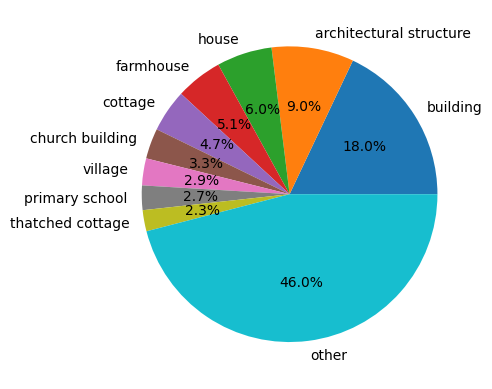

In [90]:
# PLOT PIE CHART OF PLACE BY INSTANCE TYPE BEFORE DROPPING BASED ON COORDINATE
print(places_by_instance)
print(sorted(places_by_instance.items(), key=lambda x:x[1], reverse=True))
places_by_instance_sorted = sorted(places_by_instance.items(), key=lambda x:x[1], reverse=True)

places_by_instance_10 = places_by_instance_sorted[:9]
places_by_instance_10.append(("other",sum(map(lambda x: x[1], places_by_instance_sorted[10:]))))
print(places_by_instance_10)

total_count = sum(map(lambda x: x[1], places_by_instance_10))
print(total_count)
chart_labels = []
chart_sizes = []
for inst, count in places_by_instance_10:
    chart_labels.append(inst)
    chart_sizes.append(count / total_count * 100)

print(chart_labels)
print(chart_sizes, sum(chart_sizes))

fig, ax = plt.subplots()
ax.pie(chart_sizes, labels=chart_labels, autopct='%1.1f%%')


In [73]:
places_df.drop("constituency", axis=1, inplace=True)

In [74]:
# MULTIPLE CONSTITUENCIES TO ONE ENTRY WITH LIST OF CONSTITUENCIES
places_df = places_df.groupby(["place", "placeLabel", "coordinate", "instance", "instanceLabel"])['constituencyLabel'].apply(list).reset_index()
print("unique places", places_df.shape[0])
places_df.head()

unique places 702004


,place,placeLabel,coordinate,instance,instanceLabel,constituencyLabel
0,http://www.wikidata.org/entity/Q1000115,Faversham,Point(0.8928 51.3177),http://www.wikidata.org/entity/Q3957,town,[Swale]
1,http://www.wikidata.org/entity/Q100018793,Roman Catholic Church of SS Peter and Paul,Point(-0.315267 51.504467),http://www.wikidata.org/entity/Q16970,church building,[London Borough of Ealing]
2,http://www.wikidata.org/entity/Q1000312,Sandgate,Point(1.1454 51.074),http://www.wikidata.org/entity/Q532,village,[Folkestone and Hythe]
3,http://www.wikidata.org/entity/Q1000597,Burton upon Trent,Point(-1.636666666 52.801944444),http://www.wikidata.org/entity/Q3957,town,[East Staffordshire]
4,http://www.wikidata.org/entity/Q100060717,Scrubs Lane,Point(-0.23466 51.52643),http://www.wikidata.org/entity/Q79007,street,[London Borough of Hammersmith and Fulham]


In [75]:
# SPLIT LAT AND LONGITUDE OF PLACES

latitudes = []
longitudes = []

for i in range(places_df.shape[0]):
    if places_df.loc[i, "coordinate"][:5] == "Point":
        coordinate = places_df.loc[i, "coordinate"][6:-1].split(" ")
        latitude = float(coordinate[1])
        latitudes.append(latitude)
        longitude = float(coordinate[0])
        longitudes.append(longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)


places_df["latitudes"] = latitudes
places_df["longitudes"] = longitudes


places_df.to_csv("places_query.csv")

Get Constituency according too coordinate from QGIS and then reload the updated places CSV.

In [92]:
# READ AND MERGE WITH PLACES DF
places_by_coord = pd.read_csv("places_by_coord.csv", encoding="utf-8")
places_by_coord = places_by_coord[["place", "placeLabel", "coordinate", "instance", "instanceLabel", "latitudes", "longitudes", "PCON22CD", "PCON22NM"]]
places_by_coord = pd.merge(places_by_coord, places_df, on=["place", "placeLabel", "coordinate", "instance", "instanceLabel", "latitudes", "longitudes"])
places_by_coord.head()

,place,placeLabel,coordinate,instance,instanceLabel,latitudes,longitudes,PCON22CD,PCON22NM,constituencyLabel
0,http://www.wikidata.org/entity/Q1049503,equestrian at the 1948 Summer Olympics,Point(-0.771333 51.260417),http://www.wikidata.org/entity/Q26132862,Olympic sports discipline event,51.260417,-0.771333,E14000530,Aldershot,[London]
1,http://www.wikidata.org/entity/Q106093317,Farnborough Recycling Centre,Point(-0.770036 51.28493),http://www.wikidata.org/entity/Q27106436,recycling center,51.284930,-0.770036,E14000530,Aldershot,[Hampshire]
2,http://www.wikidata.org/entity/Q106093328,Aldershot Recycling Centre,Point(-0.73863 51.24716),http://www.wikidata.org/entity/Q27106436,recycling center,51.247160,-0.738630,E14000530,Aldershot,[Hampshire]
3,http://www.wikidata.org/entity/Q111461858,Aldershot Lido,Point(-0.7476 51.23535),http://www.wikidata.org/entity/Q200023,swimming center,51.235350,-0.747600,E14000530,Aldershot,[Aldershot]
4,http://www.wikidata.org/entity/Q111789360,"Milestone, W of Blackwater just before island ...",Point(-0.786545 51.329928),http://www.wikidata.org/entity/Q10145,milestone,51.329928,-0.786545,E14000530,Aldershot,[Hart]


{'Olympic sports discipline event': 11, 'recycling center': 907, 'swimming center': 5, 'milestone': 10196, 'military museum': 92, 'museum': 2012, 'shopping arcade': 47, 'building': 117381, 'air base': 481, 'trade fair': 3, 'crypt': 1, 'English country house': 1397, 'secondary school': 3526, 'church building': 21730, 'house': 39535, 'riding school': 1, 'protestant church building': 584, 'bowl barrow': 3087, 'theatre': 1191, 'Catholic school': 11, 'railway station': 7835, 'river': 1912, 'orangery': 167, 'cottage': 30460, 'thatched cottage': 15081, 'manor house': 1527, 'farmhouse': 33396, 'thatched pub': 372, 'stable': 5167, 'clergy house': 3541, 'gatehouse': 5422, 'gate': 2682, 'town hall': 627, 'architectural structure': 58810, 'agricultural structure': 3209, 'post office': 1249, 'water tower': 171, 'almshouse': 687, 'swimming pool': 39, 'pub with rooms': 3, 'hospital building': 380, 'sculpture': 512, 'summer house': 306, 'office building': 525, 'war memorial': 5517, 'memorial': 2059, '

([<matplotlib.patches.Wedge at 0x1aee3c844f0>,
 [Text(0.8450176707139423, 0.5347383810623503, 'building'),
  Text(0.15904835432918837, 0.9872707941518258, 'architectural structure'),
  Text(-0.30788941389231983, 0.9514221506844602, 'house'),
  Text(-0.6158943649048613, 0.7878287448922117, 'farmhouse'),
  Text(-0.8251388958545637, 0.5649299094116998, 'cottage'),
  Text(-0.9395460119225931, 0.3424226795648187, 'church building'),
  Text(-0.9884129989868076, 0.15178848254694827, 'village'),
  Text(-0.9996997988785048, -0.02450126776877073, 'primary school'),
  Text(-0.9836277556248081, -0.1802122037058058, 'thatched cottage'),
  Text(0.12650497772498465, -0.9919659725065175, 'other')],
 [Text(0.5070106024283654, 0.32084302863741015, '18.0%'),
  Text(0.09542901259751302, 0.5923624764910955, '9.0%'),
  Text(-0.18473364833539188, 0.5708532904106761, '6.0%'),
  Text(-0.36953661894291673, 0.472697246935327, '5.1%'),
  Text(-0.4950833375127382, 0.3389579456470199, '4.7%'),
  Text(-0.56372760715

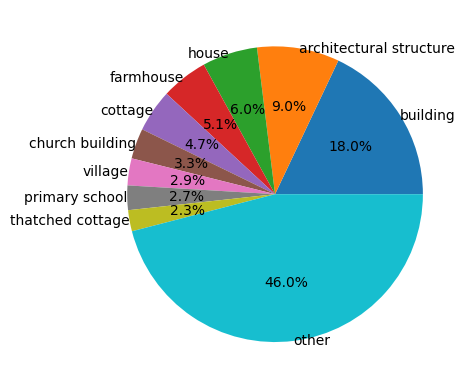

In [93]:
# Plot top 10 as pie chart
places_by_instance = {}
for i, row in places_by_coord.iterrows():
    instanceURI = row["instance"].split("/")[-1]
    instanceLabel = instanceLabels[instanceURI]
    places_by_instance[instanceLabel] = places_by_instance.get(instanceLabel, 0) + 1

print(places_by_instance)
places_by_instance_sorted = sorted(places_by_instance.items(), key=lambda x:x[1], reverse=True)
print(places_by_instance_sorted)

places_by_instance_10 = places_by_instance_sorted[:9]
places_by_instance_10.append(("other",sum(map(lambda x: x[1], places_by_instance_sorted[10:]))))
print(places_by_instance_10)

#places_by_instance_10 = sorted(places_by_instance.items(), key=lambda x:x[1], reverse=True)[:10]
total_count = sum(map(lambda x: x[1], places_by_instance_10))
print(total_count)
chart_labels = []
chart_sizes = []
for inst, count in places_by_instance_10:
    chart_labels.append(inst)
    chart_sizes.append(count / total_count * 100)

print(chart_labels)
print(chart_sizes, sum(chart_sizes))

fig, ax = plt.subplots()
ax.pie(chart_sizes, labels=chart_labels, autopct='%1.1f%%', labeldistance=1)

In [18]:
# ADD COORDINATE CONSTITUENCY TO LIST OF CONSTITUENCIES

constLabels = []
for i, row in places_by_coord.iterrows():
    #print(row['constituen'])
    wikiLabels = row['constituencyLabel']

    #print(wikiLabels)
    qgisLabels = row['PCON22NM']
    wikiLabels.append(qgisLabels)
    labels = set(wikiLabels)
    constLabels.append(labels)

places_by_coord['constLabels'] = constLabels
places_by_coord.head()

,place,placeLabel,coordinate,instance,instanceLabel,latitudes,longitudes,PCON22CD,PCON22NM,constituencyLabel,constLabels
0,http://www.wikidata.org/entity/Q1049503,equestrian at the 1948 Summer Olympics,Point(-0.771333 51.260417),http://www.wikidata.org/entity/Q26132862,Olympic sports discipline event,51.260417,-0.771333,E14000530,Aldershot,"[London, Aldershot]","{Aldershot, London}"
1,http://www.wikidata.org/entity/Q106093317,Farnborough Recycling Centre,Point(-0.770036 51.28493),http://www.wikidata.org/entity/Q27106436,recycling center,51.284930,-0.770036,E14000530,Aldershot,"[Hampshire, Aldershot]","{Aldershot, Hampshire}"
2,http://www.wikidata.org/entity/Q106093328,Aldershot Recycling Centre,Point(-0.73863 51.24716),http://www.wikidata.org/entity/Q27106436,recycling center,51.247160,-0.738630,E14000530,Aldershot,"[Hampshire, Aldershot]","{Aldershot, Hampshire}"
3,http://www.wikidata.org/entity/Q111461858,Aldershot Lido,Point(-0.7476 51.23535),http://www.wikidata.org/entity/Q200023,swimming center,51.235350,-0.747600,E14000530,Aldershot,"[Aldershot, Aldershot]",{Aldershot}
4,http://www.wikidata.org/entity/Q111789360,"Milestone, W of Blackwater just before island ...",Point(-0.786545 51.329928),http://www.wikidata.org/entity/Q10145,milestone,51.329928,-0.786545,E14000530,Aldershot,"[Hart, Aldershot]","{Aldershot, Hart}"


In [19]:
# DROP AND RENAME COLUMNS
places_by_coord = places_by_coord[['placeLabel', "constituencyLabel"]]

# Rename columns
places_by_coord.rename(columns={"placeLabel": "placeLabel", "constituencyLabel": "constLabel"}, inplace=True)
print(places_by_coord.shape[0])
places_by_coord.head()

666153


,placeLabel,constLabel
0,equestrian at the 1948 Summer Olympics,"[London, Aldershot]"
1,Farnborough Recycling Centre,"[Hampshire, Aldershot]"
2,Aldershot Recycling Centre,"[Hampshire, Aldershot]"
3,Aldershot Lido,"[Aldershot, Aldershot]"
4,"Milestone, W of Blackwater just before island ...","[Hart, Aldershot]"


In [20]:
# load places with constituency according to ONS data
ons_places = pd.read_csv("IPN_GB_2023.csv", encoding="ANSI")
total_places = ons_places.shape[0]
print(f"total places: {total_places} AND unique constituencies: {len(ons_places['pcon22nm'].unique())}")
ons_places = ons_places[['place22nm', "pcon22nm"]]
ons_places.rename(columns={"place22nm": "placeLabel", "pcon22nm": "constLabel"}, inplace=True)

# drop rows without constituency
ons_places.dropna(subset=["constLabel"], inplace=True)
ons_places.reset_index(drop=True, inplace=True)
print(f"places only with constituency labels: {total_places - ons_places.shape[0]}")
print(f"new size: {ons_places.shape[0]}")

# convert constituency label to list
ons_places['constLabel'] = ons_places['constLabel'].apply(lambda x: [x])
ons_places.head()

total places: 108464 AND unique constituencies: 633
places only with constituency labels: 10440
new size: 98024


,placeLabel,constLabel
0,A' Chill,"[Ross, Skye and Lochaber]"
1,A' Chrìon Làraich,[Stirling]
2,A' Glas Pheighinn,"[Ross, Skye and Lochaber]"
3,A' Mhointeach,"[Ross, Skye and Lochaber]"
4,A' Phairce Dhubh,"[Ross, Skye and Lochaber]"


In [21]:
# JOIN ONS PLACES AND WIKIDATA PLACES

places_df = pd.concat([places_by_coord, ons_places], axis=0, join="outer", ignore_index=True, verify_integrity=True)
print(places_df.shape)

# make lowercase before dropping duplicates
places_df['placeLabel'] = places_df['placeLabel'].map(str.lower)

places_df.to_csv("places.csv")

print(places_df.shape[0])
places_df.head()

(764177, 2)
764177


,placeLabel,constLabel
0,equestrian at the 1948 summer olympics,"[London, Aldershot]"
1,farnborough recycling centre,"[Hampshire, Aldershot]"
2,aldershot recycling centre,"[Hampshire, Aldershot]"
3,aldershot lido,"[Aldershot, Aldershot]"
4,"milestone, w of blackwater just before island ...","[Hart, Aldershot]"


In [23]:
# initialise place count constituency lookup
places_count = {}
for const in constituencies:
    if "Ynys" in const:
        print(const)
    places_count[const.lower()] = 0

print(places_count)
print(len(places_count))

# count number of places by constituency
for i, placeRow in places_df.iterrows():
    for label in placeRow['constLabel']:
        if label != None:
            label = label.lower()
            if label in places_count:
                places_count[label] += 1

max_asked = max(places_count.values())
print(max_asked)
print(places_count)
print(len(places_count))
print(sorted(places_count.keys()))

places_count_df = pd.DataFrame({"constName": places_count.keys(), "count": places_count.values()})
places_count_df.head()

Ynys Môn
{'amber valley': 0, 'blackpool south': 0, 'aldershot': 0, 'birkenhead': 0, 'henley': 0, 'brent central': 0, 'bradford south': 0, 'daventry': 0, 'canterbury': 0, 'harwich and north essex': 0, 'bury north': 0, 'coventry north west': 0, 'coventry south': 0, 'halesowen and rowley regis': 0, 'north east derbyshire': 0, 'north east cambridgeshire': 0, 'makerfield': 0, 'scarborough and whitby': 0, 'mid derbyshire': 0, 'keighley': 0, 'oldham west and royton': 0, 'west bromwich east': 0, 'nottingham north': 0, 'mid dorset and north poole': 0, 'somerton and frome': 0, 'south staffordshire': 0, 'west worcestershire': 0, 'pendle': 0, 'gravesham': 0, 'hereford and south herefordshire': 0, 'westmorland and lonsdale': 0, 'warrington north': 0, 'vauxhall': 0, 'wallasey': 0, 'ynys môn': 0, 'clwyd south': 0, 'worcester': 0, 'wirral south': 0, 'rhondda': 0, 'west dorset': 0, 'workington': 0, 'brighton, pavilion': 0, 'beaconsfield': 0, 'aylesbury': 0, 'bexhill and battle': 0, 'burton': 0, 'bolton

,constName,count
0,amber valley,648
1,blackpool south,153
2,aldershot,327
3,birkenhead,468
4,henley,3833


In [24]:
# CALCULATE PERCENTAGES OF PLACES BY CONSTITUENCY
perc = []

for i, placeCountRow in places_count_df.iterrows():
    perc.append(placeCountRow['count'] / max_asked * 100)

places_count_df['percentages'] = perc
places_count_df.head()

,constName,count,percentages
0,amber valley,648,4.893521
1,blackpool south,153,1.155415
2,aldershot,327,2.469415
3,birkenhead,468,3.534209
4,henley,3833,28.945779


In [25]:
places_count_df.to_csv("places_count.csv")

Question Preprocessing and Visualisation

In [36]:
# READ AND FORMAT QUESTION DATA FROM UK PARLIAMENTARY API
questions_df = pd.read_csv('questions_query.csv', quotechar='"', skipinitialspace=True, encoding="utf-8")
print(questions_df.shape)

questions_df = questions_df.loc[:, ~questions_df.columns.str.contains('^Unnamed')]

questions_df.head()

(27617, 16)


,question,qnum,text,date,person,name,surname,seatIncumbency,seat,constituency,house,houseName,seatIncumbencyStartDate,constituencyName,constituencyStartDate
0,https://id.parliament.uk/0IwOO533,903422,<p>Which three departments had the lowest prop...,2023-01-05+00:00,https://id.parliament.uk/Vs3bGLNz,Philip,Hollobone,https://id.parliament.uk/wiR0TXEx,https://id.parliament.uk/tpDcfKEU,https://id.parliament.uk/79YObEMl,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Kettering,2010-05-06+01:00
1,https://id.parliament.uk/dRJ9254g,117748,"<p>To ask the Secretary of State for Foreign, ...",2023-01-06+00:00,https://id.parliament.uk/eD0yd5Ec,Catherine,West,https://id.parliament.uk/TbtymCvC,https://id.parliament.uk/cR4IWVwp,https://id.parliament.uk/H2TVOJgH,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Hornsey and Wood Green,2010-05-06+01:00
2,https://id.parliament.uk/e4IDRkKi,117410,"<p>To ask the Secretary of State for Foreign, ...",2023-01-06+00:00,https://id.parliament.uk/RlIqlixq,Timothy,Loughton,https://id.parliament.uk/UWWa5GU5,https://id.parliament.uk/OEV2U2ZQ,https://id.parliament.uk/YqIfQuKs,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,East Worthing and Shoreham,2010-05-06+01:00
3,https://id.parliament.uk/rXZ0r1JW,117477,"<p>To ask the Secretary of State for Foreign, ...",2023-01-06+00:00,https://id.parliament.uk/1DzMUkBy,Fabian,Hamilton,https://id.parliament.uk/I8imum8M,https://id.parliament.uk/8dnnjjvi,https://id.parliament.uk/EH8hmrNu,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Leeds North East,2010-05-06+01:00
4,https://id.parliament.uk/SmC4cGhg,117777,<p>To ask the Secretary of State for Health an...,2023-01-06+00:00,https://id.parliament.uk/tOfis7j9,Sarah,Olney,https://id.parliament.uk/XQNx9njJ,https://id.parliament.uk/UVpLA3KR,https://id.parliament.uk/MDExJLK4,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Richmond Park,2010-05-06+01:00


In [38]:
# REMOVE WHITE SPACE AND <P> TAG FROM DATAFRAME
def remove_whitespace(df):
    df.rename(str.strip, axis="columns", inplace=True)
    for i in df.columns:
        df[i] = df[i].str.strip()
        if i == "text":
            df[i] = df[i].map(lambda x: x[3:-4])

remove_whitespace(questions_df)
print(questions_df.columns)
questions_df.head()

Which three departments had the lowest proportion of staff attending the office in January 2023.
Index(['question', 'qnum', 'text', 'date', 'person', 'name', 'surname',
       'seatIncumbency', 'seat', 'constituency', 'house', 'houseName',
       'seatIncumbencyStartDate', 'constituencyName', 'constituencyStartDate'],
      dtype='object')


,question,qnum,text,date,person,name,surname,seatIncumbency,seat,constituency,house,houseName,seatIncumbencyStartDate,constituencyName,constituencyStartDate
0,https://id.parliament.uk/0IwOO533,903422,Which three departments had the lowest proport...,2023-01-05+00:00,https://id.parliament.uk/Vs3bGLNz,Philip,Hollobone,https://id.parliament.uk/wiR0TXEx,https://id.parliament.uk/tpDcfKEU,https://id.parliament.uk/79YObEMl,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Kettering,2010-05-06+01:00
1,https://id.parliament.uk/dRJ9254g,117748,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/eD0yd5Ec,Catherine,West,https://id.parliament.uk/TbtymCvC,https://id.parliament.uk/cR4IWVwp,https://id.parliament.uk/H2TVOJgH,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Hornsey and Wood Green,2010-05-06+01:00
2,https://id.parliament.uk/e4IDRkKi,117410,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/RlIqlixq,Timothy,Loughton,https://id.parliament.uk/UWWa5GU5,https://id.parliament.uk/OEV2U2ZQ,https://id.parliament.uk/YqIfQuKs,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,East Worthing and Shoreham,2010-05-06+01:00
3,https://id.parliament.uk/rXZ0r1JW,117477,"To ask the Secretary of State for Foreign, Com...",2023-01-06+00:00,https://id.parliament.uk/1DzMUkBy,Fabian,Hamilton,https://id.parliament.uk/I8imum8M,https://id.parliament.uk/8dnnjjvi,https://id.parliament.uk/EH8hmrNu,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Leeds North East,2010-05-06+01:00
4,https://id.parliament.uk/SmC4cGhg,117777,To ask the Secretary of State for Health and S...,2023-01-06+00:00,https://id.parliament.uk/tOfis7j9,Sarah,Olney,https://id.parliament.uk/XQNx9njJ,https://id.parliament.uk/UVpLA3KR,https://id.parliament.uk/MDExJLK4,https://id.parliament.uk/1AFu55Hs,House of Commons,2019-12-12+00:00,Richmond Park,2010-05-06+01:00


In [39]:
# COUNT AND REMOVE NON-MPs
total_questions = questions_df.shape[0]
questions_df.dropna(subset=['seatIncumbency', 'seat', 'constituency', 'house', 'houseName',
       'seatIncumbencyStartDate', 'constituencyName', 'constituencyStartDate'], inplace=True)
questions_df.reset_index(drop=True, inplace=True)

mps_only_count = questions_df.shape[0]

print("number of non-mp questions:", total_questions - mps_only_count, "out of", total_questions)
print(f"number of mp questions: {mps_only_count}")

number of non-mp questions: 2472 out of 27617
number of mp questions: 25145


In [41]:
questions_df = questions_df[['question', "text", "name", "surname", "constituencyName"]]

In [42]:
# initialise constituencies lookup
question_count = {}
for const in constituencies:
    question_count[const] = 0

In [78]:
# COUNT QUESTIONS BY CONSTITUENCY
for i, questionRow in questions_df.iterrows():
    const = questionRow['constituencyName']
    question_count[const] = question_count.get(const, 0) + 1

max_asked = max(question_count.values())
print(max_asked)
print(question_count)
print(len(question_count))
print(sorted(question_count.keys()))

count_df = pd.DataFrame({"constituencyName": question_count.keys(), "count": question_count.values()})
count_df.head()

2834
{'Amber Valley': 10, 'Blackpool South': 0, 'Aldershot': 0, 'Birkenhead': 0, 'Henley': 98, 'Brent Central': 66, 'Bradford South': 76, 'Daventry': 0, 'Canterbury': 118, 'Harwich and North Essex': 14, 'Bury North': 0, 'Coventry North West': 0, 'Coventry South': 0, 'Halesowen and Rowley Regis': 2, 'North East Derbyshire': 0, 'North East Cambridgeshire': 0, 'Makerfield': 12, 'Scarborough and Whitby': 6, 'Mid Derbyshire': 38, 'Keighley': 0, 'Oldham West and Royton': 110, 'West Bromwich East': 0, 'Nottingham North': 80, 'Mid Dorset and North Poole': 0, 'Somerton and Frome': 122, 'South Staffordshire': 38, 'West Worcestershire': 18, 'Pendle': 0, 'Gravesham': 20, 'Hereford and South Herefordshire': 0, 'Westmorland and Lonsdale': 282, 'Warrington North': 0, 'Vauxhall': 0, 'Wallasey': 42, 'Ynys Môn': 0, 'Clwyd South': 0, 'Worcester': 16, 'Wirral South': 256, 'Rhondda': 16, 'West Dorset': 0, 'Workington': 0, 'Brighton, Pavilion': 610, 'Beaconsfield': 0, 'Aylesbury': 0, 'Bexhill and Battle': 0

AttributeError: 'dict_keys' object has no attribute 'map'

In [79]:
# CALCULATE QUESTIONS ASKED FOR EACH CONSTITUENCY BY PERCENTAGE
perc = []
for i, countRow in count_df.iterrows():
    perc.append(countRow['count'] / max_asked * 100)

count_df['percentage'] = perc
count_df['constituencyName'] = count_df['constituencyName'].map(str.lower)

count_df.to_csv("question_count.csv")
count_df.head()

,constituencyName,count,percentage
0,amber valley,5,0.176429
1,blackpool south,0,0.000000
2,aldershot,0,0.000000
3,birkenhead,0,0.000000
4,henley,49,1.729005


In [127]:
# GET TAGGED ENTITIES ACCORDING TO NTLK STANFORD NER - TAKES A LONG TIME TO RUN
# Code adapted from https://pythonprogramming.net/named-entity-recognition-stanford-ner-tagger/

"""st = StanfordNERTagger("D:\Sam\Programs2\stanford-ner\classifiers\english.all.3class.distsim.crf.ser.gz", 
                    "D:\Sam\Programs2\stanford-ner\stanford-ner.jar", encoding="utf-8")

classified_questions = []
questions_tagged_entities = []

for i in range(questions_df.shape[0]):
    question_text = questions_df.loc[i, "text"]
    #print(question_text)
    

    tokenized_question = word_tokenize(question_text)
    classified_question = st.tag(tokenized_question)
    classified_questions.append(classified_question)

    tagged_entities = []

    for token, tokenClass in classified_question:
        if tokenClass != "O":
            tagged_entities.append((token, tokenClass))

    questions_tagged_entities.append(tagged_entities)

# add classified questions and question's tagged entities to df
questions_df['classified_questions'] = classified_questions
questions_df['questions_tagged_entities'] = questions_tagged_entities 

questions_df.head()"""

KeyboardInterrupt: 

In [ ]:
#questions_df.to_csv("questions_ner.csv")

In [45]:
nlp = stanza.Pipeline(lang="en", processors="tokenize,ner")

2024-01-11 13:36:19 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-01-11 13:36:19 WARNING: Language en package default expects mwt, which has been added
2024-01-11 13:37:07 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2024-01-11 13:37:07 INFO: Using device: cuda
2024-01-11 13:37:07 INFO: Loading: tokenize
2024-01-11 13:37:08 INFO: Loading: mwt
2024-01-11 13:37:08 INFO: Loading: ner
2024-01-11 13:37:08 INFO: Done loading processors!


In [46]:
# GET TAGGED ENTITIES via STANZA LIBRARY
# Code adapted from https://stanfordnlp.github.io/stanza/getting_started.html
classified_questions = []
questions_tagged_entities = []

for i, row in questions_df.iterrows():
    if i % 100 == 0:
        print(i)
    doc = nlp(row['text'])
    tagged_entities = []

    for ent in doc.ents:
        #print(ent.text, ent.type)
        if ent.type != "PERSON":
            tagged_entities.append((ent.text, ent.type))
    
    questions_tagged_entities.append(tagged_entities)

questions_df['questions_tagged_entities_stanza'] = questions_tagged_entities 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [47]:
questions_df.to_csv("questions_ner.csv")

In [55]:
# Get list of questions that are referencing location in constituency & 
# list of questions with direct ref to constituency
questions_have_ref = []
questions_ref_constituency = []
questions_fuzzy_ref = []

for i, questionRow in questions_df.iterrows():
    # tracking (REMOVE)
    if i % 100 == 0:
        print(i)
    
    question_have_ref = False
    question_ref_const = False

    question_fuzzy_ref = False

    for ent_name, ent_type in questionRow['questions_tagged_entities_stanza']:
        #print("entName", ent_name,"--", questionRow["constituencyName"])
        question_const = questionRow["constituencyName"].strip().lower()
        
        # check if entity name is the constituency of the person asking the question
        if fuzz.ratio(ent_name.lower(), question_const) > 95:
            print("matched constituency", ent_name, question_const, i)
            question_ref_const = True

        # get list of matches for place
        matching_places = places_df[places_df['placeLabel'].str.lower() == ent_name.lower()]
        
        # check that places constituency is the same as questioner's constituency
        for j, placeRow in matching_places.iterrows():
            for const in placeRow['constLabel']:
                if const != None:
                    const = const.lower()
                    if const == question_const: # LOWER?
                        question_have_ref = True
                    if fuzz.ratio(const, question_const) > (len(const) - 2) / len(const) * 100:
                        question_fuzzy_ref = True
        
        if question_have_ref:
            print("match found", ent_name, placeRow['placeLabel'], question_const, i)

    questions_have_ref.append(question_have_ref)
    questions_ref_constituency.append(question_ref_const)
    questions_fuzzy_ref.append(question_fuzzy_ref)

questions_df['is_ref'] = questions_have_ref
questions_df["is_direct_ref"] = questions_ref_constituency
questions_df['is_fuzzy_ref'] = questions_fuzzy_ref

0
matched constituency Easington easington 28
match found Easington easington easington 28
match found the Office of Life Sciences easington easington 28
matched constituency Weston-super-Mare weston-super-mare 48
match found Weston-super-Mare weston-super-mare weston-super-mare 48
match found 2 November 2022 weston-super-mare weston-super-mare 48
match found 1 December 2022 weston-super-mare weston-super-mare 48
match found Ukrainian weston-super-mare weston-super-mare 48
matched constituency Slough slough 52
match found Slough slough slough 52
matched constituency Weston-super-Mare weston-super-mare 70
match found Weston-super-Mare weston-super-mare weston-super-mare 70
match found Hounslow hounslow brentford and isleworth 83
100
match found York york york central 142
match found UK york york central 142
match found the last 12 months york york central 142
matched constituency Wirral West wirral west 143
match found Wirral West wirral west wirral west 143
match found Feltham feltham 

In [51]:
questions_df.to_csv("questions_flagged.csv")

In [56]:
# GET NUMBER OF MATCHES FOUND (DIRECT AND INDIRECT)
matched = questions_df[questions_df['is_ref'] == True]
matched_direct = questions_df[questions_df['is_direct_ref'] == True]
fuzzy_matched = questions_df[questions_df['is_fuzzy_ref'] == True]

print("matched", len(matched), "direct match", len(matched_direct))
print(f"fuzzy: {len(fuzzy_matched)}")

matched 1086 direct match 526
fuzzy: 1096


In [61]:
# COUNT REFERENCES BY CONSTITUENCY
# initialise constituencies
refs_count = {}
direct_refs_count = {}
fuzzy_refs_count = {}

for const in constituencies:
    refs_count[const.lower()] = 0
    direct_refs_count[const.lower()] = 0
    fuzzy_refs_count[const.lower()] = 0

for i, questionRow in questions_df.iterrows():
    const = questionRow['constituencyName'].lower()
    if questionRow['is_ref']:
        refs_count[const] += 1
    elif questionRow['is_direct_ref']:
        direct_refs_count[const] += 1
    elif questionRow['is_fuzzy_ref']:
        fuzzy_refs_count[const] += 1

        

max_direct_refs = max(direct_refs_count.values())
max_refs = max(refs_count.values())

print(len(refs_count), len(direct_refs_count))
print(refs_count)
print(direct_refs_count)

refs_count_df = pd.DataFrame({"constName": refs_count.keys(), 
                              "count": refs_count.values(),
                              "direct_count": direct_refs_count.values(),
                              "fuzzy_count": fuzzy_refs_count.values()
                              })
refs_count_df.head()

650 650
{'amber valley': 0, 'blackpool south': 0, 'aldershot': 0, 'birkenhead': 0, 'henley': 1, 'brent central': 2, 'bradford south': 0, 'daventry': 0, 'canterbury': 5, 'harwich and north essex': 0, 'bury north': 0, 'coventry north west': 0, 'coventry south': 0, 'halesowen and rowley regis': 0, 'north east derbyshire': 0, 'north east cambridgeshire': 0, 'makerfield': 0, 'scarborough and whitby': 3, 'mid derbyshire': 0, 'keighley': 0, 'oldham west and royton': 0, 'west bromwich east': 0, 'nottingham north': 0, 'mid dorset and north poole': 0, 'somerton and frome': 4, 'south staffordshire': 1, 'west worcestershire': 1, 'pendle': 0, 'gravesham': 1, 'hereford and south herefordshire': 0, 'westmorland and lonsdale': 2, 'warrington north': 0, 'vauxhall': 0, 'wallasey': 1, 'ynys môn': 0, 'clwyd south': 0, 'worcester': 0, 'wirral south': 4, 'rhondda': 1, 'west dorset': 0, 'workington': 0, 'brighton, pavilion': 7, 'beaconsfield': 0, 'aylesbury': 0, 'bexhill and battle': 0, 'burton': 0, 'bolton 

,constName,count,direct_count,fuzzy_count
0,amber valley,0,0,0
1,blackpool south,0,0,0
2,aldershot,0,0,0
3,birkenhead,0,0,0
4,henley,1,0,0


In [62]:
refs_count_df.to_csv("refs_count.csv")